In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%R

# My commonly used R imports

require('tidyverse')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse


## Load the data

In [4]:
%%R
df <- read_csv('merged_df_census_mda.csv')
df

Rows: 24147 Columns: 111
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): lei, state_code, derived_ethnicity, derived_race, derived_sex, der...
dbl (98): census_tract, activity_year, county_code, loan_type, business_or_c...
lgl  (1): denial_reason.4

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 24,147 × 111
   census_tract activity_year lei       state_code county_code derived_ethnicity
          <dbl>         <dbl> <chr>     <chr>            <dbl> <chr>            
 1  36005000200          2023 RVDPPPGH… NY               36005 Ethnicity Not Av…
 2  36005000200          2023 RVDPPPGH… NY               36005 Ethnicity Not Av…
 3  36005000200          2023 DRMSV1Q0… NY               36005 Ethnicity Not Av…
 4  36005000200          2023 DRMSV1Q0… NY               36005 Hispanic or Lati…
 5  36005000200          20

In addition: Warning message:
One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat) 


In [5]:
%%R
df[c("loan_amount", "loan_purpose", "denial_reason.1")]


# A tibble: 24,147 × 3
   loan_amount loan_purpose denial_reason.1
         <dbl>        <dbl>           <dbl>
 1      515000            1              10
 2      565000            1              10
 3      185000            2               1
 4       85000            4              10
 5      765000            1              10
 6      125000            4               4
 7      455000           32              10
 8      105000            2               9
 9      145000           32              10
10       25000            2              10
# ℹ 24,137 more rows
# ℹ Use `print(n = ...)` to see more rows


In [6]:
%%R

print("All column names:")
print(list(df))

[1] "All column names:"
[[1]]
# A tibble: 24,147 × 111
   census_tract activity_year lei       state_code county_code derived_ethnicity
          <dbl>         <dbl> <chr>     <chr>            <dbl> <chr>            
 1  36005000200          2023 RVDPPPGH… NY               36005 Ethnicity Not Av…
 2  36005000200          2023 RVDPPPGH… NY               36005 Ethnicity Not Av…
 3  36005000200          2023 DRMSV1Q0… NY               36005 Ethnicity Not Av…
 4  36005000200          2023 DRMSV1Q0… NY               36005 Hispanic or Lati…
 5  36005000200          2023 RVDPPPGH… NY               36005 Ethnicity Not Av…
 6  36005000200          2023 DRMSV1Q0… NY               36005 Hispanic or Lati…
 7  36005000200          2023 5493008N… NY               36005 Ethnicity Not Av…
 8  36005000200          2023 DRMSV1Q0… NY               36005 Hispanic or Lati…
 9  36005000200          2023 549300FG… NY               36005 Hispanic or Lati…
10  36005000200          2023 WWB2V0FC… NY            

Normalize by tract 

In [7]:
%%R
df <- df %>%
  mutate(
    estimated_household_size = population / total_households,
    income_per_person = median_household_income / estimated_household_size
  )


In [8]:
%%R
df['loan_amount']

# A tibble: 24,147 × 1
   loan_amount
         <dbl>
 1      515000
 2      565000
 3      185000
 4       85000
 5      765000
 6      125000
 7      455000
 8      105000
 9      145000
10       25000
# ℹ 24,137 more rows
# ℹ Use `print(n = ...)` to see more rows


In [9]:
%%R
df_tagged <- df %>%
  filter(loan_purpose == 1) %>%
  mutate(
    outlier_type = case_when(
      loan_amount > 10000000 ~ "High Outlier",
      loan_amount < 50000 ~ "Lowest Outlier",   
      loan_amount < 100000 ~ "Low Outlier",
      loan_amount < 825000 ~ "Typical",
      TRUE ~ "Other"
    )
  )


# Highest loans 

In [10]:
%%R
library(ggplot2)
library(ggrepel)
library(scales)

ggplot(df_tagged, aes(x = income_per_person, y = loan_amount)) +
  geom_point(alpha = 0.2, color = "#d3d3d3") +
  geom_point(
    data = df_tagged %>% filter(outlier_type == "High Outlier"),
    aes(x = income_per_person, y = loan_amount),
    color = "red", size = 3
  ) +
  geom_text_repel(
    data = df_tagged %>% filter(outlier_type == "High Outlier"),
    aes(label = census_tract),
    size = 3,
    max.overlaps = 10
  ) +
  scale_x_continuous(labels = comma) +
  scale_y_continuous(labels = comma) +
  labs(
    title = "Home Purchase Loans — Loans more than $10,000,000",
    x = "Income per Household Member",
    y = "Loan Amount"
  ) +
  theme_minimal()
  ggsave("high_outliers.png")


Saving 6.67 x 6.67 in image



Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

In addition: Warning message:
Removed 95 rows containing missing values or values outside the scale range
(`geom_point()`). 


# Less than 100k 

In [11]:
%%R 
ggplot(df_tagged, aes(x = income_per_person, y = loan_amount)) +
  geom_point(alpha = 0.2, color = "#d3d3d3") +
  geom_point(
    data = df_tagged %>% filter(outlier_type == "Low Outlier"),
    aes(x = income_per_person, y = loan_amount),
    color = "orange", size = 3
  ) +
  geom_text_repel(
    data = df_tagged %>% filter(outlier_type == "Low Outlier"),
    aes(label = census_tract),
    size = 3,
    max.overlaps = 10
  ) +
  scale_x_continuous(labels = comma) +
  scale_y_continuous(labels = comma) +
  labs(
    title = "Home Purchase Loans — Loans less than $100,000",
    subtitle = "> 150 rows, with 36047022700 and 36005022404 having the lowest loan amounts",
    x = "Income per Household Member",
    y = "Loan Amount"
  ) +
  theme_minimal()
  ggsave("less_than_100k_outliers.png")


Saving 6.67 x 6.67 in image


In addition: Warning messages:
1: Removed 95 rows containing missing values or values outside the scale range
(`geom_point()`). 
2: ggrepel: 108 unlabeled data points (too many overlaps). Consider increasing max.overlaps 


In [12]:
%%R
#Check why only one low outlier is highlighted  
df_tagged %>% 
  filter(outlier_type == "Low Outlier") %>%
  distinct(census_tract) %>%
  nrow()



[1] 94


# Lowest outlier  less than 50k 

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 95 rows containing missing values or values outside the scale range
(`geom_point()`). 

R[write to console]: 2: ggrepel: 77 unlabeled data points (too many overlaps). Consider increasing max.overlaps 



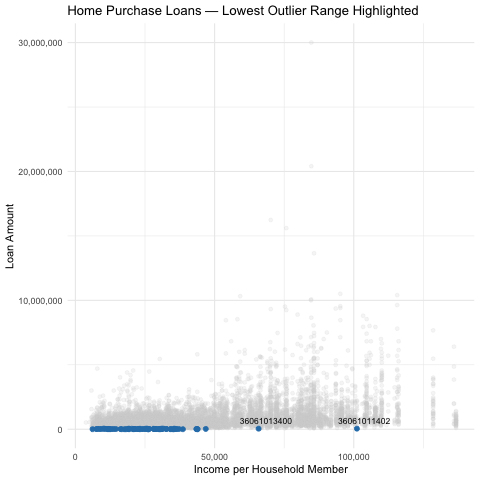

In [13]:
%%R
ggplot(df_tagged, aes(x = income_per_person, y = loan_amount)) +
  geom_point(alpha = 0.2, color = "#d3d3d3") +
  geom_point(
    data = df_tagged %>% filter(outlier_type == "Lowest Outlier"),
    aes(x = income_per_person, y = loan_amount),
    color = "#2c7fb8", size = 2
  ) +
  geom_text_repel(
    data = df_tagged %>% filter(outlier_type == "Lowest Outlier"),
    aes(label = census_tract),
    size = 3,
    max.overlaps = 10
  ) +
  scale_x_continuous(labels = comma) +
  scale_y_continuous(labels = comma) +
  labs(
    title = "Home Purchase Loans — Lowest Outlier Range Highlighted",
    x = "Income per Household Member",
    y = "Loan Amount"
  ) +
  theme_minimal()


In [14]:
%%R
df_tagged %>%
  count(outlier_type)


# A tibble: 5 × 2
  outlier_type       n
  <chr>          <int>
1 High Outlier      10
2 Low Outlier      109
3 Lowest Outlier    79
4 Other           3374
5 Typical         8943


In [15]:
%%R
#Check why only one low outlier is highlighted  
df_tagged %>% 
  filter(outlier_type == "Lowest Outlier") %>%
  distinct(census_tract) %>%
  nrow()



[1] 73


In [16]:
%%R
df_tagged %>%
  filter(outlier_type == "Lowest Outlier") %>%
  count(census_tract, sort = TRUE)


# A tibble: 73 × 2
   census_tract     n
          <dbl> <int>
 1  36005022404     2
 2  36005025300     2
 3  36047051100     2
 4  36047081400     2
 5  36081077905     2
 6  36081104700     2
 7  36005003500     1
 8  36005005902     1
 9  36005006301     1
10  36005013200     1
# ℹ 63 more rows
# ℹ Use `print(n = ...)` to see more rows


 # Loan Purpose Frequency per Tract

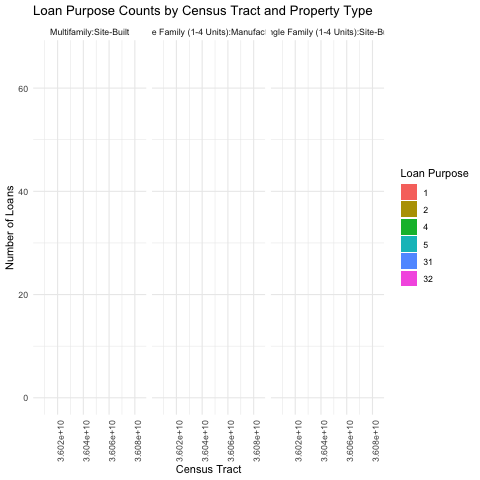

In [17]:
%%R
library(dplyr)
library(ggplot2)

df_plot <- df %>%
  filter(!is.na(loan_purpose)) %>%
  group_by(census_tract, loan_purpose, derived_dwelling_category) %>%
  summarise(n = n(), .groups = "drop")

ggplot(df_plot, aes(x = census_tract, y = n, fill = as.factor(loan_purpose))) +
  geom_col(position = "dodge") +
  facet_wrap(~ derived_dwelling_category) +
  labs(
    title = "Loan Purpose Counts by Census Tract and Property Type",
    x = "Census Tract",
    y = "Number of Loans",
    fill = "Loan Purpose"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))


# Logistic Regression  by Tract and Dwelling Type

In [18]:
%%R
df_model <- df %>%
  filter(loan_purpose %in% c(1, 2)) %>%
  mutate(
    loan_home_purchase = ifelse(loan_purpose == 1, 1, 0),
    dwelling_type = as.factor(derived_dwelling_category)
  )

model <- glm(loan_home_purchase ~ census_tract + dwelling_type, data = df_model, family = "binomial")

summary(model)



Call:
glm(formula = loan_home_purchase ~ census_tract + dwelling_type, 
    family = "binomial", data = df_model)

Coefficients:
                                                      Estimate Std. Error
(Intercept)                                          1.863e+01  3.288e+01
census_tract                                        -4.363e-10  9.112e-10
dwelling_typeSingle Family (1-4 Units):Manufactured  7.668e+00  1.195e+02
dwelling_typeSingle Family (1-4 Units):Site-Built   -1.608e+00  1.028e+00
                                                    z value Pr(>|z|)
(Intercept)                                           0.567    0.571
census_tract                                         -0.479    0.632
dwelling_typeSingle Family (1-4 Units):Manufactured   0.064    0.949
dwelling_typeSingle Family (1-4 Units):Site-Built    -1.565    0.118

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 16699  on 15975  degrees of freedom
Residual deviance: 16694  on 15972  degre

`geom_smooth()` using formula = 'y ~ x'


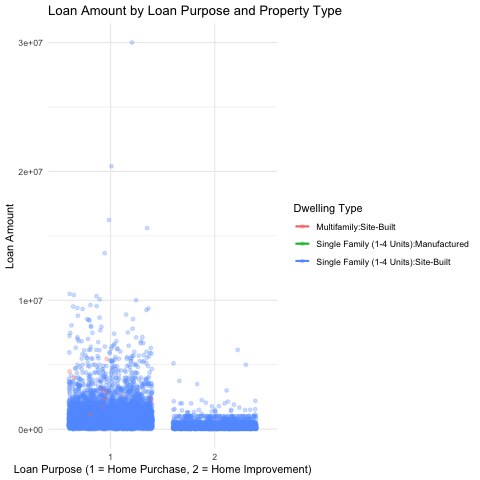

In [170]:
%%R
library(dplyr)
library(ggplot2)

df_plot <- df %>%
  filter(!is.na(loan_purpose)) %>%
  group_by(census_tract, loan_purpose, derived_dwelling_category) %>%
  summarise(n = n(), .groups = "drop")

# Get top 20 census tracts with the most loans
top_tracts <- df_plot %>%
  group_by(census_tract) %>%
  summarise(total = sum(n)) %>%
  slice_max(order_by = total, n = 20) %>%
  pull(census_tract)

# Filter for just those tracts
df_top_plot <- df_plot %>%
  filter(census_tract %in% top_tracts)

# Plot
ggplot(df_top_plot, aes(x = as.factor(census_tract), y = n, fill = as.factor(loan_purpose))) +
  geom_col(position = "dodge") +
  facet_wrap(~ derived_dwelling_category) +
  labs(
    title = "Loan Purpose by Property Type in Top 20 Census Tracts",
    x = "Census Tract",
    y = "Number of Loans",
    fill = "Loan Purpose"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))


In [174]:
%%R
df_plot <- df %>%
  filter(!is.na(loan_purpose)) %>%
  mutate(
    loan_purpose_label = recode(
      loan_purpose,
      `1` = "Home Purchase",
      `2` = "Home Improvement",
      `31` = "Refinancing",
      `32` = "Cash-out Refinancing",
      `4` = "Other Purpose",
      `5` = "Not Applicable"
    )
  ) %>%
  group_by(census_tract, loan_purpose_label, derived_dwelling_category) %>%
  summarise(n = n(), .groups = "drop")


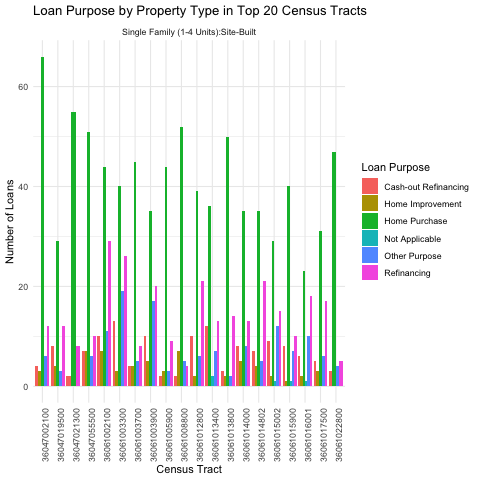

In [176]:
%%R
# Get top 20 tracts by total loans
top_tracts <- df_plot %>%
  group_by(census_tract) %>%
  summarise(total = sum(n)) %>%
  slice_max(order_by = total, n = 20) %>%
  pull(census_tract)

# Filter and plot
df_top_plot <- df_plot %>%
  filter(census_tract %in% top_tracts)

ggplot(df_top_plot, aes(x = as.factor(census_tract), y = n, fill = loan_purpose_label)) +
  geom_col(position = "dodge") +
  facet_wrap(~ derived_dwelling_category) +
  labs(
    title = "Loan Purpose by Property Type in Top 20 Census Tracts",
    x = "Census Tract",
    y = "Number of Loans",
    fill = "Loan Purpose"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))


In [177]:
%%R
df_business <- df %>%
  filter(business_or_commercial_purpose == 1) %>%
  mutate(
    loan_purpose_label = recode(
      loan_purpose,
      `1` = "Home Purchase",
      `2` = "Home Improvement",
      `31` = "Refinancing",
      `32` = "Cash-out Refinancing",
      `4` = "Other Purpose",
      `5` = "Not Applicable"
    )
  ) %>%
  group_by(census_tract, loan_purpose_label, derived_dwelling_category) %>%
  summarise(n = n(), .groups = "drop")


In [179]:
%%R
top_business_tracts <- df_business %>%
  group_by(census_tract) %>%
  summarise(total = sum(n)) %>%
  slice_max(order_by = total, n = 20) %>%
  pull(census_tract)


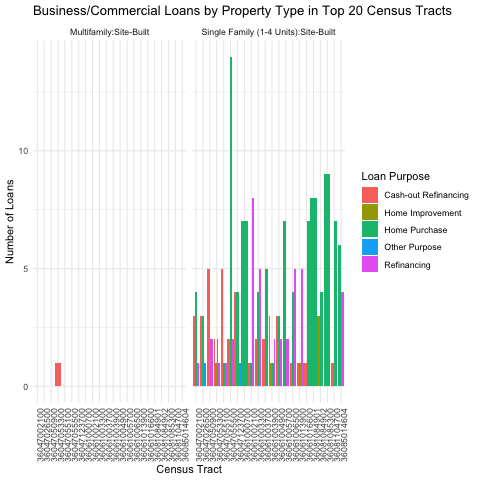

In [184]:
%%R
df_business_top <- df_business %>%
  filter(census_tract %in% top_business_tracts)

ggplot(df_business_top, aes(x = as.factor(census_tract), y = n, fill = loan_purpose_label)) +
  geom_col(position = "dodge") +
  facet_wrap(~ derived_dwelling_category) +
  labs(
    title = "Business/Commercial Loans by Property Type in Top 20 Census Tracts",
    x = "Census Tract",
    y = "Number of Loans",
    fill = "Loan Purpose"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))
